# Primeira aula: Is it a bird?

Na primeira aula do FastAI, que possui um caracter mais introdutório, é demonstrado para o aluno como as redes neurais passaram a permitir, com a melhora na sua capacidade, a resolução de problemas que hoje se tornaram simples de resolver. Para demonstrar esse ponto o professor Jeremy Howard demonstra na prática como pode ser feito um modelo para diferenciar pássaro de floresta em 2022.

# Objetivo

* Com o objetivo de identificar alunos em uma escola, esse artigo terá como proposta desenvolver um modelo que diferencie um estudante de qualquer outra pessoa. Antes de começar é necessário importar algumas bibliotecas para facilitar o processo de desenvolvimento do projeto proposto, as bibliotecas principais que serão utilizadas são a do próprio FastAI e a do DuckDuckGo (tem como objetivo permitir pesquisar fotos de cachorros e gatos).

In [2]:
# Importar a biblioteca OS permite utilizar comandos para instalar blibliotecas como é feito a seguir.
import os
!pip install -Uqq fastai duckduckgo_search

# Dessas bibliotecas importadas será utilizado apenas algumas funcionalidades, portanto para não sobrecarregar o modelo, 
# iremos importas apenas funcionalidades selecionadas. 

from duckduckgo_search import ddg_images
from fastcore.all import *

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


# 1. Buscando e armazenando fotos 

Apos importar bibliotecas é possível então pesquisar por imagens relacionadas ao projeto. No meu caso irei pesquisar imagens de estudantes com uniforme, trabalhadores, assaltantes e soldados.

In [4]:
# Essa função terá como objetivo pesquisar por imagens deacordo com o termo que for sugerido para buscar no DuckDuckGo

def buscar_imagens(term, max_images=100):
    print(f"Buscando por '{term}'")
# ddg_images é uma funcionalidade da biblioteca importada.
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Definida a função responsável por buscar fotos no DuckDuckGo, é possível agora pesquisar fotos de estudantes, soldados, trabalhadores e ladrões! Para melhorar a exatidão do modelo, será tambem pesquisado imagens de uniformes escolares.

Será criado um loop com o objetivo de salvar em uma pasta as imagens encontradas e que foram feito o dowload. 


In [68]:
# Termos que serão utilizados na busca.
searches = 'student', 'worker','robber', 'soldier'
# O caminho da pasta que será gerada para armazenar
path = Path('student_or_not')
# Importando função sleep para não sobrecarregar o servidor
from time import sleep
from fastai.vision.all import *

dest = (path/'student')
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=buscar_imagens(f'public school uniform photo'))
sleep(3)
download_images(dest, urls=buscar_imagens(f'school uniform photo'))
sleep(3)
download_images(dest, urls=buscar_imagens(f'private school uniform photo'))
sleep(3)
resize_images(path/'student', max_size=400, dest=path/'student')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=buscar_imagens(f'young {o} photo'))
    sleep(3)
    download_images(dest, urls=buscar_imagens(f'happy {o} photo'))
    sleep(3)
    download_images(dest, urls=buscar_imagens(f'{o} photo'))
    sleep(3)
    resize_images(path/o, max_size=400, dest=path/o)

Buscando por 'public school uniform photo'
Buscando por 'school uniform photo'
Buscando por 'private school uniform photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Buscando por 'young student photo'
Buscando por 'happy student photo'
Buscando por 'student photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Buscando por 'young worker photo'
Buscando por 'happy worker photo'
Buscando por 'worker photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Buscando por 'young robber photo'
Buscando por 'happy robber photo'
Buscando por 'robber photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Buscando por 'young soldier photo'
Buscando por 'happy soldier photo'
Buscando por 'soldier photo'


# 2. Hora de treinar o modelo

Apos ser feito o dowload das imagens e o seu armazenamento devemos treinar o modelo para identificar um estudante. Para isso será necessário antes retirar imagens quebradas, ao fazer a pesquisa e o dowload de imagens pelo DuckDuckGo algumas das imagens encontradas podem ter tido problemas ao ser feito o dowload. Logo, para resolver esse possível problema eleminaremos imagens que não tiveram êxito no dowload.

In [69]:
failed = verify_images(get_image_files(path))
# Após identificar as imagens que tiveram um problema ao realizar o dowload elas serão eliminadas.
failed.map(Path.unlink)
# Irá demonstrar a quatidade de imagens que falharam.
len(failed)

12

Após eleminar possíveis erros nos dowloads, é necessário um DataLoader que é um objeto que possui uma série de dados (nesse caso imagens) para treinar o modelo e validações que são utilizadas para verificar o grau de acertividade. A biblioteca do FastAI facilita esse processo com a utilização do chamado DataBlock que possui uma série de parâmetros para deixar ainda mais configurável o treinamento do modelo.

Os parâmetros que iremos passar estão definindo:
1. ```blocks=(ImageBlock, CategoryBlock)``` O input do DataBlock será imagens e o output será cada categoria.
2. ```get_items=get_image_files``` As imagens utilizadas serão das que foram feito dowload.
3. ```splitter=RandomSplitter(valid_pct=0.2, seed=42)``` Irá definir 20% das imagens para serem usadas como validação do modelo.
4. ```get_y=parent_label``` A definição da imagen entre estudante, trabalhador, soldado e assaltante.
5. ```item_tfms=[Resize(192, method='squish')]``` Define o tamanho da imagem para 192x192.

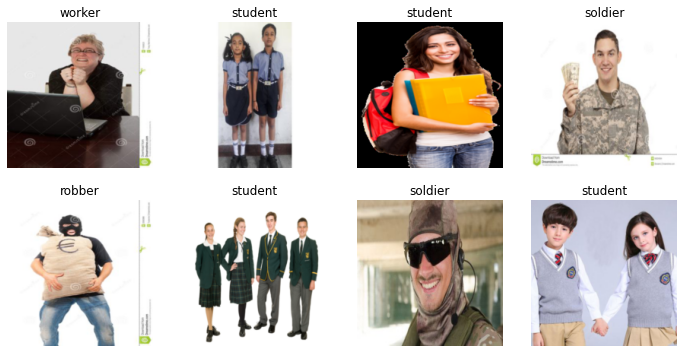

In [70]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

Agora que os dados para ser feito o treinamento foram devidamente configurados estamos prontos para treinar o modelo. O modelo mais famoso é o resnet18. Esse modelo é definido por Yashvi Chandola e Papendra Kumar, no [Deep Learning for Chest Radiographs](https://www.sciencedirect.com/book/9780323901840/deep-learning-for-chest-radiographs) de 2021 como:
> The primary idea of ResNet is the use of jumping connections that are mostly referred to as shortcut connections or identity connections. These connections primarily function by hopping over one or multiple layers forming shortcuts between these layers. The aim of introducing these shortcut connections was to resolve the predominant issue of vanishing gradient faced by deep networks. These shortcut connections remove the vanishing gradient issue by again using the activations of the previous layer. These identity mappings initially do not do anything much except skip the connections, resulting in the use of previous layer activations. This process of skipping the connection compresses the network; hence, the network learns faster.

O **Learner** permite agrupar o DataBlock com o modelo que deve ser treinado e a métrica que será utilizada. Além disso a biblioteca do FastAI possui uma funcionalidade muito útil a **fine_tune**, essa função permite que de maneira simples você indique para modelos pré-treinados utilizarem boas práticas, ou seja irá pegar modelos pré-treinados, nesse caso o resnet18 e ajustar para o propósito desejado. Mais detalhes sobre o **fine_tune** podem ser encontrados [aqui](https://forums.fast.ai/t/understanding-fine-tuning/54142/2).

In [101]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.338794,0.591096,0.193772,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.497532,0.506370,0.186851,00:07
1,0.326435,0.463716,0.166090,00:07
2,0.214348,0.501820,0.162630,00:07
3,0.147664,0.515021,0.159170,00:08
4,0.100261,0.553763,0.162630,00:07
5,0.069848,0.532945,0.166090,00:07
6,0.049769,0.620499,0.159170,00:07
7,0.047324,0.610468,0.169550,00:08
8,0.046868,0.637400,0.162630,00:07
9,0.065772,0.658614,0.193772,00:07


Após concluido esse processo estamos prontos para testar o modelo!

# 3. Testando o modelo

Fazendo o dowload de uma imagem de um estudante da escola pública do Rio de Janeiro para testar a capacidade do modelo.

Buscando por 'foto estudante uniforme escola rio de janeiro'


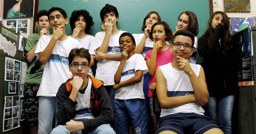

In [102]:
from fastdownload import download_url
from fastai.vision.all import *

urls = buscar_imagens('foto estudante uniforme escola rio de janeiro', max_images=1)
dest = 'test.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)


Testando modelo com imagem baixada anteriormente.

In [103]:
student_or_not,_,probs = learn.predict(PILImage.create('test.jpg'))
print(f"This is a: {student_or_not}.")
print(f"Probability it's a student: {probs[2]:.4f}")

This is a: student.
Probability it's a student: 0.9625


Fazendo dowload de iamgem de um advogado para testar capacidade do modelo.

Buscando por 'foto marinheiro homem'


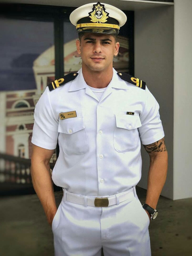

In [115]:
urls = buscar_imagens('foto marinheiro homem', max_images=1)
dest = 'test.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Ao fazer o teste percebi que o modelo ainda não conseguia identificar corretamente um estudante em alguns casos específicos como por exemplo um marinheiro, em que dava apenas 50% de certeza de ser um trabalhador e 49% de que era um estudante. Para diminuir esse erro adicionei uma quantidade maior de fotos para serem utilizadas, com a adição de fotos de uniforme escolarcom algumas variações, e aumentei a quantidade de ```fine_tune``` para 50 com o propósito de melhorar a capacidade de identificação.

Testando modelo com imagem baixada anteriormente.

In [116]:
student_or_not,_,probs = learn.predict(PILImage.create('test.jpg'))
print(f"This is a: {student_or_not}.")
print(f"Probability it's a student: {probs[2]:.4f}")

This is a: worker.
Probability it's a student: 0.0007


Após as alterações descritas acima percebe-se que a capacidade do modelo de identificar um estudante de um não estudante melhorou consideravelmente, com agora certeza que a foto não se trata de um estudate com apenas 0.07% de probabilidade. Apesar de estar avaliando a mesma foto o modelo conseguiu melhorar sua performance com o aumento de repetições do ```fine_tune```  e maior quantidade de imagens para treinar.